In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import pathlib
import os
import PIL

import torchvision.transforms as transforms
import torchvision.datasets

from itertools import islice

## Load data from tensor

In [4]:
# Create a tensor
t = torch.arange(6, dtype=torch.float32)
print(t)
# Create a dataloader from the tensor
data_loader = torch.utils.data.DataLoader(t)

tensor([0., 1., 2., 3., 4., 5.])


In [9]:
# Iterate directly over the tensor
for item in t:
    print(item)

tensor(0.)
tensor(1.)
tensor(2.)
tensor(3.)
tensor(4.)
tensor(5.)


In [8]:
# Iterate over all entries
for item in data_loader:
    print(item)

tensor([0.])
tensor([1.])
tensor([2.])
tensor([3.])
tensor([4.])
tensor([5.])


Note that in the above case, we can either iterate over the tensor directly, or create a dataloader first and then iterate over the dataloader. To use the first method, the tensor must be loaded into computer memory, which can be impossible when the tensor is large. The second method avoid this problem by creating an iterable object. Moreover, as shown below, we can divide the data into batches and shuffle the data with dataloader. This is another advantage.

Also, iterating over the tensor directly returns scalar tensors. However, iterating over the dataloader returns 1D tensor. The reason is that the dataloader is more general and treat each row of the data as an example. The benefit is that an example may have multiple features, and the dataloader can return all features in this example.

In [11]:
# Create batches
# drop_last: drop the last batch when the total number of examples is not divisible by the batch size
data_loader = torch.utils.data.DataLoader(t, batch_size=4, drop_last=False) 
for i, item in enumerate(data_loader, 1): # enumerate(..., 1) makes the index i starting from 1 instead of 0.
    print(f"Batch {i}:", item)

data_loader = torch.utils.data.DataLoader(t, batch_size=3, drop_last=False) 
for i, item in enumerate(data_loader, 1): # enumerate(..., 1) makes the index i starting from 1 instead of 0.
    print(f"Batch {i}:", item)
    
data_loader = torch.utils.data.DataLoader(t, batch_size=4, drop_last=True) 
for i, item in enumerate(data_loader, 1): # enumerate(..., 1) makes the index i starting from 1 instead of 0.
    print(f"Batch {i}:", item)

Batch 1: tensor([0., 1., 2., 3.])
Batch 2: tensor([4., 5.])
Batch 1: tensor([0., 1., 2.])
Batch 2: tensor([3., 4., 5.])
Batch 1: tensor([0., 1., 2., 3.])


In [12]:
# Combine tensors
torch.manual_seed(1)
t_X = torch.rand([4,3], dtype=torch.float32)
t_y = torch.arange(4)
print(t_X)
print(t_y)

tensor([[0.7576, 0.2793, 0.4031],
        [0.7347, 0.0293, 0.7999],
        [0.3971, 0.7544, 0.5695],
        [0.4388, 0.6387, 0.5247]])
tensor([0, 1, 2, 3])


In [13]:
# Create a class for joining data
# It seems that this is not necessary, because pytorch has a function called torch.utils.data.TensorDataset that joins two tensors to form a dataset.
class JointDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X) # This returns the number of rows (number of examples) in X
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [14]:
# Join data
joint_dataset = JointDataset(t_X, t_y)

In [15]:
# Iterate over the joint data
for example in joint_dataset:
    print("features:", example[0], "label", example[1])

features: tensor([0.7576, 0.2793, 0.4031]) label tensor(0)
features: tensor([0.7347, 0.0293, 0.7999]) label tensor(1)
features: tensor([0.3971, 0.7544, 0.5695]) label tensor(2)
features: tensor([0.4388, 0.6387, 0.5247]) label tensor(3)


In [16]:
# Shuffle data
torch.manual_seed(1) # It seems that the previous seed does not work here, and we need to specify a new seed.
data_loader = DataLoader(dataset=joint_dataset, batch_size=2, shuffle=True)
for i, batch in enumerate(data_loader, 1):
    print(f"Batch {i}, ", "X:", batch[0], " y:", batch[1])

Batch 1,  X: tensor([[0.3971, 0.7544, 0.5695],
        [0.7576, 0.2793, 0.4031]])  y: tensor([2, 0])
Batch 2,  X: tensor([[0.7347, 0.0293, 0.7999],
        [0.4388, 0.6387, 0.5247]])  y: tensor([1, 3])


In [17]:
# Iterate over all data and shuffle the data at each epoch
# We just need to nest the above for loop inside another loop
# We don't need to create a new dataloader during each epoch.
for epoch in range(1, 2+1, 1):
    print(f'epoch {epoch}')
    for i, batch in enumerate(data_loader, 1):
        print(f"Batch {i}, ", "X:", batch[0], " y:", batch[1])

epoch 1
Batch 1,  X: tensor([[0.7576, 0.2793, 0.4031],
        [0.3971, 0.7544, 0.5695]])  y: tensor([0, 2])
Batch 2,  X: tensor([[0.7347, 0.0293, 0.7999],
        [0.4388, 0.6387, 0.5247]])  y: tensor([1, 3])
epoch 2
Batch 1,  X: tensor([[0.4388, 0.6387, 0.5247],
        [0.3971, 0.7544, 0.5695]])  y: tensor([3, 2])
Batch 2,  X: tensor([[0.7576, 0.2793, 0.4031],
        [0.7347, 0.0293, 0.7999]])  y: tensor([0, 1])


## Load data from image files

In [18]:
# pathlib.Path is a Python module that provides an object-oriented approach 
# to working with file system paths in a platform-independent manner.
# To create such an object, the desired path should be provided.
# Note that this only deals with path. It does not load any image.
imgdir = pathlib.Path('data/Ch12_Cat_Dog_Images')
# Show all image names in the folder
# pathlib.Path.glob(): a method that returns a generator that yields all files and directories 
# that match a specified pattern in the current directory
# In the following, all jpg files are shown.
for path in imgdir.glob('*.jpg'):
    print(path)
# Although the paths for the files are printed, they are actually WindowsPath objects, see the next cell.

data\Ch12_Cat_Dog_Images\cat-01.jpg
data\Ch12_Cat_Dog_Images\cat-02.jpg
data\Ch12_Cat_Dog_Images\cat-03.jpg
data\Ch12_Cat_Dog_Images\dog-01.jpg
data\Ch12_Cat_Dog_Images\dog-02.jpg
data\Ch12_Cat_Dog_Images\dog-03.jpg


In [19]:
# Create file path list

# This will return a list of WindowsPath objects, which is not convenient for future use
file_list = [path for path in imgdir.glob('*.jpg')]
print(file_list)

# Here the paths are converted to strings for further use
file_list = [str(path) for path in imgdir.glob('*.jpg')]
print(file_list)

# This is the code from the book
# I do not quite understand why sorting the list.
# It seems that the sorted list is the same as the original.
file_list = sorted([str(path) for path in imgdir.glob('*.jpg')]) 
print(file_list)

[WindowsPath('data/Ch12_Cat_Dog_Images/cat-01.jpg'), WindowsPath('data/Ch12_Cat_Dog_Images/cat-02.jpg'), WindowsPath('data/Ch12_Cat_Dog_Images/cat-03.jpg'), WindowsPath('data/Ch12_Cat_Dog_Images/dog-01.jpg'), WindowsPath('data/Ch12_Cat_Dog_Images/dog-02.jpg'), WindowsPath('data/Ch12_Cat_Dog_Images/dog-03.jpg')]
['data\\Ch12_Cat_Dog_Images\\cat-01.jpg', 'data\\Ch12_Cat_Dog_Images\\cat-02.jpg', 'data\\Ch12_Cat_Dog_Images\\cat-03.jpg', 'data\\Ch12_Cat_Dog_Images\\dog-01.jpg', 'data\\Ch12_Cat_Dog_Images\\dog-02.jpg', 'data\\Ch12_Cat_Dog_Images\\dog-03.jpg']
['data\\Ch12_Cat_Dog_Images\\cat-01.jpg', 'data\\Ch12_Cat_Dog_Images\\cat-02.jpg', 'data\\Ch12_Cat_Dog_Images\\cat-03.jpg', 'data\\Ch12_Cat_Dog_Images\\dog-01.jpg', 'data\\Ch12_Cat_Dog_Images\\dog-02.jpg', 'data\\Ch12_Cat_Dog_Images\\dog-03.jpg']


Image shape: (900, 1200, 3)
Image shape: (900, 1200, 3)
Image shape: (900, 742, 3)
Image shape: (800, 1200, 3)
Image shape: (800, 1200, 3)
Image shape: (900, 1200, 3)


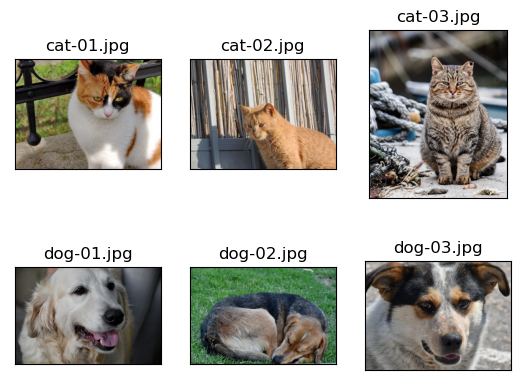

In [20]:
# Show the images here
fig, axs = plt.subplots(nrows=2, ncols=3)
axs = axs.flatten()
for i, file in enumerate(file_list):
    # This loads the images.
    img = PIL.Image.open(file)
    # np.array(img) converts each image into 3D array
    # The first two dimensions correspond to image size
    # The third dimension corresponds to RGB values.
    print("Image shape:", np.array(img).shape)
    axs[i].imshow(img)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    # os.path.basename() returns the base name of a file path, 
    # which is the last component of the path, without the directory path. 
    # This method is useful when you need to extract just the name of a file from its full path.
    axs[i].set_title(os.path.basename(file))

In [21]:
# Assign 0, 1 labels
labels = [1 if 'dog' in os.path.basename(file) else 0 for file in file_list]
print(labels)

[0, 0, 0, 1, 1, 1]


In [35]:
# Join the features and the labels
# This demonstrates the necessity of creating a dataset class by ourselves.
# In this class, we can combine loading and transforming images together.
class ImageDataset(Dataset):
    def __init__(self, file_list, labels, transform=None):
        self.file_list = file_list # file_list should be a list of file names including their paths, as strings
        self.labels = labels
        self.transform = transform # used to transform image data to get a common shape
    
    def __getitem__(self, index):
        img = PIL.Image.open(self.file_list[index])
        if self.transform is not None:
            img = self.transform(img)
        label = self.labels[index]
        return img, label
    
    def __len__(self):
        return len(self.labels)

In [23]:
# Test the ImageDataset class
image_dataset = ImageDataset(file_list, labels)
for file, label in image_dataset:
    print(file, label)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1200x900 at 0x20919E1E160> 0
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1200x900 at 0x20919D2CE20> 0
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=742x900 at 0x20919E222E0> 0
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1200x800 at 0x20919D039D0> 1
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1200x800 at 0x20919E1E160> 1
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1200x900 at 0x20919E1ED30> 1


In [24]:
# Transform the image data so that they have the same shape
img_height, img_width = 80, 120
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((img_height, img_width), antialias=True), 
])

In [25]:
# Create a generator to load and transform images
image_dataset = ImageDataset(file_list, labels, transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image shape: (3, 80, 120)
Image shape: (3, 80, 120)
Image shape: (3, 80, 120)
Image shape: (3, 80, 120)
Image shape: (3, 80, 120)
Image shape: (3, 80, 120)


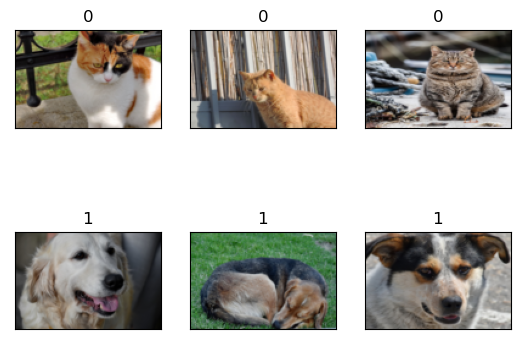

In [26]:
# Show the transformed images
fig, axs = plt.subplots(nrows=2, ncols=3)
axs = axs.flatten()
for i, example in enumerate(image_dataset):
    # np.array(img) converts each image into 3D array
    # The first two dimensions correspond to image size
    # The third dimension corresponds to RGB values.
    print("Image shape:", np.array(example[0]).shape)
    # Note that the shape of the figures is (3, 80, 120).
    # The RGB value is set as the first dimension, after transformation.
    # Therefore, to correctly show the image, we need to transpose it.
    # The following code specifies how to permute the dimensions.
    axs[i].imshow(example[0].numpy().transpose((1,2,0)))
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    # os.path.basename() returns the base name of a file path, 
    # which is the last component of the path, without the directory path. 
    # This method is useful when you need to extract just the name of a file from its full path.
    axs[i].set_title(f'{example[1]}')

    
# There may be a warning: "Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers)."
# This is because after transformation some RGB channel values fall outside [0, 1]. In my case, the maximum RGB channel value is 1.0000002, which is why I received the above warning. But this is a minor issue and the images are still correctly displayed

## Load data from torchvision.datasets

In [27]:
# This will load the data
# The data must be store in a folder called "celeba" under the folder "data"
# When specifying the path of the data, only use './data', not './data/celeba'
celeba_dataset = torchvision.datasets.CelebA(
    './data',
    split='train',
    target_type='attr',
    download=False
)
# split='train': only import the training set
# target_type: the target contains the attributes of the images
# download=False: do not download images online, since they have been downloaded.

In [28]:
# Check whether celeba_dataset is torch.utils.data.Dataset class
assert isinstance(celeba_dataset, torch.utils.data.Dataset)
# Nothing will show up after executing this cell.
# If celeba_dataset is not an instance of the torch.utils.data.Dataset class, the assertion will fail and an AssertionError will be raised, which will prevent the program from continuing and alert the user that something unexpected has happened.

In [29]:
# Show a single example from the dataset
example = next(iter(celeba_dataset))
print(example)

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=178x218 at 0x20919E06F10>, tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1]))


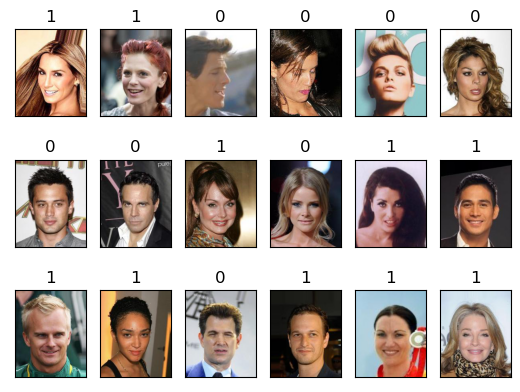

In [30]:
# Show the first 18 images
# Label them according to the 'Smiling' feature, which has index 31


fig, axs = plt.subplots(nrows=3, ncols=6)
axs = axs.flatten()
for i, (image, features) in islice(enumerate(celeba_dataset),18):
    axs[i].imshow(image)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title(f'{features[31]}')

## Load MNIST dataset with torchvision

In [31]:
# Download the data set online
mnist_dataset = torchvision.datasets.MNIST(
    root='./data/MNIST',
    train=True,
    download=True
)

In [32]:
# Check whether mnist_dataset is torch.utils.data.Dataset class
assert isinstance(mnist_dataset, torch.utils.data.Dataset)

In [33]:
# Show a single example from the dataset
example = next(iter(mnist_dataset))
print(example)

(<PIL.Image.Image image mode=L size=28x28 at 0x20919C7A9D0>, 5)


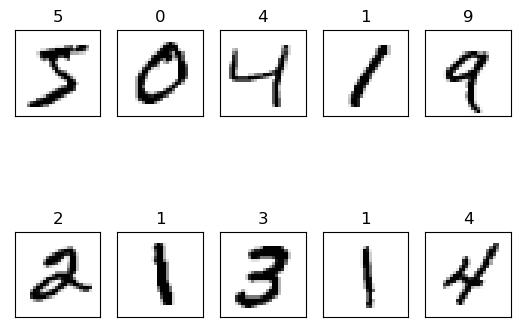

In [34]:
# Show the first 18 images
# Label them according to the 'Smiling' feature, which has index 31
fig, axs = plt.subplots(nrows=2, ncols=5)
axs = axs.flatten()
for i, (image, label) in islice(enumerate(mnist_dataset), 10):
    axs[i].imshow(image, cmap='gray_r')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title(f'{label}')